### Import libraries

In [2]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib
%matplotlib inline
import folium

### Loading data

In [3]:
DATA_FOLDER = 'data'
FOOD_FILE = 'food_data.csv'
COUNTRIES_FILE = 'countries_info.csv'
OVERWEIGHT_FILE = 'overweight.csv'
DIABETES_FILE = 'diabetes.csv'
POPULATION_FILE = 'population.csv'
IHD_FILE = 'ihd.csv'
JSON_COUNTRIES_FILE = 'world-countries.json'

In [4]:
all_datas = pd.read_csv(DATA_FOLDER + "/" + FOOD_FILE, sep='\t', low_memory=False)
countries_infos = pd.read_csv(DATA_FOLDER + "/" + COUNTRIES_FILE, sep=',', low_memory=False)
overweight = pd.read_csv(DATA_FOLDER + "/" + OVERWEIGHT_FILE, sep=',', low_memory=False)
diabetes = pd.read_csv(DATA_FOLDER + '/' + DIABETES_FILE, low_memory=False)
ihd = pd.read_csv(DATA_FOLDER + '/' + IHD_FILE, low_memory=False)
population = pd.read_csv(DATA_FOLDER + '/' + POPULATION_FILE, low_memory=False)
countries_shapes = pd.read_json(DATA_FOLDER + '/' + JSON_COUNTRIES_FILE, orient='columns')

### Analysis of the different fields available in the dataset

We have to select only the features which is possible to help us to answer our questions

In [5]:
for col in all_datas.columns.values:
    print("- ", col)

-  code
-  url
-  creator
-  created_t
-  created_datetime
-  last_modified_t
-  last_modified_datetime
-  product_name
-  generic_name
-  quantity
-  packaging
-  packaging_tags
-  brands
-  brands_tags
-  categories
-  categories_tags
-  categories_en
-  origins
-  origins_tags
-  manufacturing_places
-  manufacturing_places_tags
-  labels
-  labels_tags
-  labels_en
-  emb_codes
-  emb_codes_tags
-  first_packaging_code_geo
-  cities
-  cities_tags
-  purchase_places
-  stores
-  countries
-  countries_tags
-  countries_en
-  ingredients_text
-  allergens
-  allergens_en
-  traces
-  traces_tags
-  traces_en
-  serving_size
-  serving_quantity
-  no_nutriments
-  additives_n
-  additives
-  additives_tags
-  additives_en
-  ingredients_from_palm_oil_n
-  ingredients_from_palm_oil
-  ingredients_from_palm_oil_tags
-  ingredients_that_may_be_from_palm_oil_n
-  ingredients_that_may_be_from_palm_oil
-  ingredients_that_may_be_from_palm_oil_tags
-  nutrition_grade_uk
-  nutrition_grade_f

We can deduce the usefull colums for our project:
 - product_name
 - sugars_100g
 - fat_100g
 - nutrition_grade_fr
 - countries
 - countries_tags


### Datasets clean
We clean our datasets. We select only the potential interesting fields. 

We do some operations on the countries tags to be able to parse the data. We also remove potential outliers.
In our case, some outliers may be having a larger sugar or fat content than 100g, since it defies the laws of physics :-p 

In [6]:
countries_infos = countries_infos[['COUNTRY_ALPHA2_CODE', 'COUNTRY_NAME', 'COUNTRY_ALPHA3_CODE']]

In [7]:
usefull_datas = all_datas.copy()
to_keep = ['product_name', 'countries','countries_tags','sugars_100g','fat_100g','serving_quantity','energy_100g',
           'carbohydrates_100g','proteins_100g','salt_100g','sodium_100g','saturated-fat_100g',
           'ingredients_text', 'additives',  'fiber_100g','serving_size', 'additives_en']
usefull_datas = usefull_datas[to_keep]

#only do this for full na set
#usefull_datas.dropna(inplace=True)
usefull_datas['countries_tags'] = usefull_datas['countries_tags'].replace(regex=True, to_replace=r'\w\w:', value=r'')
usefull_datas['countries'].replace(regex=True, inplace=True, to_replace=r'\w\w:', value=r'')
usefull_datas['countries'].replace(regex=True, inplace=True, to_replace=r'-', value=r' ')
usefull_datas['countries'] = usefull_datas['countries'].apply(lambda x: str(x).lower())
usefull_datas = usefull_datas[usefull_datas['sugars_100g'] <= 100]
usefull_datas = usefull_datas[usefull_datas['fat_100g'] <= 100]
#get a feel of the data
usefull_datas.head()

,product_name,countries,countries_tags,sugars_100g,fat_100g,serving_quantity,energy_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,saturated-fat_100g,ingredients_text,additives,fiber_100g,serving_size,additives_en
0,Vitória crackers,france,france,15.0,7.0,0,1569.0,70.1,7.8,1.400,0.551181,3.08,NaN,NaN,NaN,NaN,NaN
2,Sauce Sweety chili 0%,france,france,0.4,0.0,0,88.0,4.8,0.2,2.040,0.803150,0.00,NaN,NaN,NaN,NaN,NaN
4,Salade de carottes râpées,france,france,3.9,0.3,0,134.0,5.3,0.9,0.420,0.165354,0.10,NaN,NaN,NaN,NaN,NaN
5,Fromage blanc aux myrtilles,france,france,16.3,4.9,0,540.0,16.3,4.4,0.250,0.098425,3.10,NaN,NaN,NaN,NaN,NaN
8,Baguette parisien,france,france,1.8,3.3,0,929.0,38.4,11.7,0.678,0.266929,2.10,NaN,NaN,NaN,NaN,NaN


We contruct a datastructure with the countries codes map to their names (in different languages), in order to group all the different ways the countries were written together

In [8]:

countries = []

for c in usefull_datas['countries_tags'].dropna():
    #split list of countries on the comma
    for country in c.split(','):
        country = country.lower()
        found = re.search('\w\w:(.+)', country, re.IGNORECASE)  
        if found:
            country = found.group(1)
        if country not in countries:
            countries.append(country)

countries_with_code = []
#apply lower case to country names
countries_infos['COUNTRY_NAME'] = countries_infos['COUNTRY_NAME'].apply(lambda x: str(x).lower())

for c in countries:
    is_present = False
    #loop over rows having matching country names with countries data
    for index, c_i in countries_infos[countries_infos['COUNTRY_NAME'] == c.lower()].iterrows():
        #add tuple containing country name and country code
        countries_with_code.append((c, c_i['COUNTRY_ALPHA2_CODE'], c_i['COUNTRY_ALPHA3_CODE']))
        is_present = True
        break
    if not is_present:
        countries_with_code.append((c, "???", "???"))

We select only the countries for which we have information. (They are contained in the open food database)

In [9]:
count = 0
proper_countries = []
for c in countries_with_code:
    if c[1] != "???":
        proper_countries.append(c)

In [10]:
to_append = [('united-states', 'US'), ('united-kingdom', 'UK'), ('french-polynesia', 'PF'),
             ('hong-kong', 'HK'), ('new-zealand', 'NZ'), ('new-caledonia', 'NC'),
             ('scotland','GB'), ('united-arab-emirates', 'AE'), ('etats-unis', 'US'),
             ('czech-republic', 'CZ'), ('south-africa', 'ZA'), ('quebec', 'CA'), 
             #('saint-pierre-and-miquelon', 'FR'),('french-guiana', 'FR'), ('dom-tom', 'FR'),
             ('south-korea', 'KR'), 
            ('usa','US','USA')]
for i in to_append:
    proper_countries.append(i)

In [11]:
proper_countries

[('france', 'FR', 'FRA'),
 ('canada', 'CA', 'CAN'),
 ('oman', 'OM', 'OMN'),
 ('germany', 'DE', 'DEU'),
 ('belgium', 'BE', 'BEL'),
 ('netherlands', 'NL', 'NLD'),
 ('australia', 'AU', 'AUS'),
 ('switzerland', 'CH', 'CHE'),
 ('egypt', 'EG', 'EGY'),
 ('mexico', 'MX', 'MEX'),
 ('italy', 'IT', 'ITA'),
 ('spain', 'ES', 'ESP'),
 ('saudi-arabia', 'SA', 'SAU'),
 ('iraq', 'IQ', 'IRQ'),
 ('sverige', 'SE', 'SWE'),
 ('sweden', 'SE', 'SWE'),
 ('vietnam', 'VN', 'VNM'),
 ('singapore', 'SG', 'SGP'),
 ('thailand', 'TH', 'THA'),
 ('greece', 'GR', 'GRC'),
 ('panama', 'PA', 'PAN'),
 ('malaysia', 'MY', 'MYS'),
 ('luxembourg', 'LU', 'LUX'),
 ('lebanon', 'LB', 'LBN'),
 ('denmark', 'DK', 'DNK'),
 ('guyana', 'GY', 'GUY'),
 ('serbia', 'RS', 'SRB'),
 ('martinique', 'MQ', 'MTQ'),
 ('barbados', 'BB', 'BRB'),
 ('ireland', 'IE', 'IRL'),
 ('aruba', 'AW', 'ABW'),
 ('bahrain', 'BH', 'BHR'),
 ('taiwan', 'TW', 'TWN'),
 ('cuba', 'CU', 'CUB'),
 ('portugal', 'PT', 'PRT'),
 ('kuwait', 'KW', 'KWT'),
 ('austria', 'AT', 'AUT'),
 

When a rows mention many countries we explode the dataframe to get one line for each country.

In [12]:
def explode(df):
    rows = []
    for index, data in df.iterrows():
        countries = str(data['countries_tags']).split(',')
        for country in countries:
            data['countries'] = country
            rows.append(data)
    return pd.DataFrame(rows)

In [13]:
exploded_data = explode(usefull_datas)

In [14]:
proper_countries

[('france', 'FR', 'FRA'),
 ('canada', 'CA', 'CAN'),
 ('oman', 'OM', 'OMN'),
 ('germany', 'DE', 'DEU'),
 ('belgium', 'BE', 'BEL'),
 ('netherlands', 'NL', 'NLD'),
 ('australia', 'AU', 'AUS'),
 ('switzerland', 'CH', 'CHE'),
 ('egypt', 'EG', 'EGY'),
 ('mexico', 'MX', 'MEX'),
 ('italy', 'IT', 'ITA'),
 ('spain', 'ES', 'ESP'),
 ('saudi-arabia', 'SA', 'SAU'),
 ('iraq', 'IQ', 'IRQ'),
 ('sverige', 'SE', 'SWE'),
 ('sweden', 'SE', 'SWE'),
 ('vietnam', 'VN', 'VNM'),
 ('singapore', 'SG', 'SGP'),
 ('thailand', 'TH', 'THA'),
 ('greece', 'GR', 'GRC'),
 ('panama', 'PA', 'PAN'),
 ('malaysia', 'MY', 'MYS'),
 ('luxembourg', 'LU', 'LUX'),
 ('lebanon', 'LB', 'LBN'),
 ('denmark', 'DK', 'DNK'),
 ('guyana', 'GY', 'GUY'),
 ('serbia', 'RS', 'SRB'),
 ('martinique', 'MQ', 'MTQ'),
 ('barbados', 'BB', 'BRB'),
 ('ireland', 'IE', 'IRL'),
 ('aruba', 'AW', 'ABW'),
 ('bahrain', 'BH', 'BHR'),
 ('taiwan', 'TW', 'TWN'),
 ('cuba', 'CU', 'CUB'),
 ('portugal', 'PT', 'PRT'),
 ('kuwait', 'KW', 'KWT'),
 ('austria', 'AT', 'AUT'),
 

In [15]:
def get_tag(row, col1, col2):
    for c in proper_countries:
        if c[0] == row[col1]:
            row[col2] = c[1]
            return row
    row[col2] = "TBD"
    return row


In [16]:
parsed_datas = exploded_data.apply(lambda x: get_tag(x, 'countries', 'countries_tags'), axis=1)

In [17]:
parsed_datas[parsed_datas['countries_tags'] == 'TBD']['countries']

16156                           nan
18669                           nan
28009                           nan
29665                           nan
39468                            en
39468                            en
39637                            en
39637                            en
39637                            en
60715                            en
60715                            en
60717                            en
60717                            en
62054                           nan
66219                           nan
67654                estadps-unidos
67654                estadps-unidos
71723     saint-pierre-and-miquelon
71748     saint-pierre-and-miquelon
71954                           nan
72963                           nan
73015     saint-pierre-and-miquelon
73068     saint-pierre-and-miquelon
74524                           nan
74948     saint-pierre-and-miquelon
74948     saint-pierre-and-miquelon
75985     saint-pierre-and-miquelon
75985     saint-pierre-and-m

In [18]:
parsed_datas[parsed_datas['countries_tags'] == 'TBD']['countries'].value_counts()

en                                     645
french-guiana                          163
nan                                    127
saint-pierre-and-miquelon               50
dom-tom                                 43
reino-unido                             13
vereinigtes-konigreich                  13
suede                                   10
european-union                          10
republic-of-macedonia                    9
europe                                   8
grece                                    8
republic-of-the-congo                    7
verenigd-koninkrijk                      7
franca                                   6
magyarorszag                             5
cote-d-ivoire                            5
carrefour                                5
tahiti                                   5
polyensie-francaise                      5
cee                                      4
draveil                                  4
costa-rica                               4
england    

In [19]:
parsed_datas['countries_tags'].value_counts()

FR     359837
US     162818
CH      19008
DE      13852
ES       6625
UK       6295
IT       2015
MX       1502
BE       1420
SE       1269
TBD      1262
NL       1189
PT        911
CA        775
AU        677
RS        594
RO        587
RE        529
IE        431
LU        411
GP        402
HU        370
PF        361
MQ        275
MA        271
NC        228
PL        205
RU        199
NZ        187
TN        173
        ...  
AL          4
SZ          4
VE          4
VU          4
ME          4
KE          3
AZ          3
PK          3
IQ          3
GN          3
MO          3
EE          3
LY          2
HR          2
MD          2
ML          2
MZ          2
TG          2
FJ          2
EC          2
NG          2
NE          2
CM          2
PA          2
GT          1
AW          1
HT          1
GI          1
NI          1
DM          1
Name: countries_tags, Length: 121, dtype: int64

### Get results
Now we compute result from the parsed datasets. We would like to get the mean average of sugar and fat per 100g per country.

In [20]:
grouped = parsed_datas.groupby(['countries_tags'])
means = grouped.mean()
means

,sugars_100g,fat_100g,energy_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,saturated-fat_100g,fiber_100g
countries_tags,,,,,,,,,
AD,1.708000,6.512000,765.260000,19.920000,9.618000,0.964800,0.379850,2.617800,7.060000
AE,24.628485,15.450000,1384.106061,39.059385,7.841875,2.103947,0.828316,6.596970,5.310811
AL,8.925000,3.900000,605.250000,23.100000,3.750000,0.711250,0.280020,1.700000,0.000000
AR,25.568333,17.087222,1436.055556,41.694444,7.921111,0.453892,0.178870,6.327056,1.392667
AT,8.482282,14.494228,1042.677852,22.854189,6.966622,1.812700,0.713633,5.407014,2.953333
AU,12.631958,10.899496,971.815503,25.068539,7.121200,2.162995,0.851402,4.489083,4.113697
AW,8.000000,17.300000,2000.000000,70.000000,8.000000,1.770380,0.697000,8.000000,1.400000
AZ,0.000000,0.200000,738.666667,72.000000,0.000000,0.010000,0.003937,0.000000,0.000000
BE,12.411555,14.417484,1154.092158,28.206091,10.360003,1.163297,0.457987,4.990863,2.818800


In [21]:
grouped = parsed_datas.groupby(['countries_tags'])
counted = grouped.count()

In [22]:
sugar = means[['sugars_100g']].dropna()
#remove outliers
sugar = sugar[sugar['sugars_100g'] <= 100]
#we would like to have countries with a big enough sample of values in the database, we choose 20 for now
sugar = sugar[counted['sugars_100g'] > 20]
#sort values
sugar.sort_values(by=['sugars_100g'], ascending=False, inplace=True)

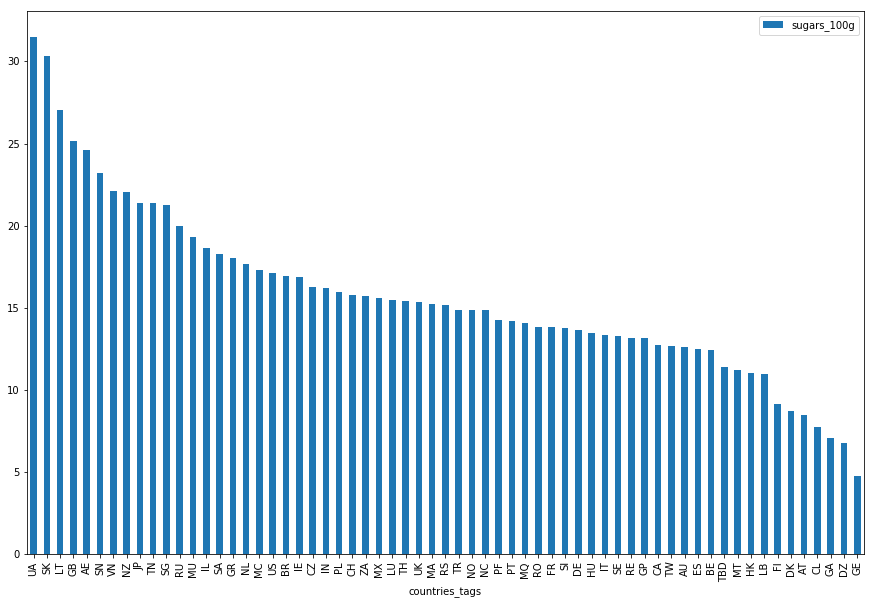

In [23]:
sugar.plot.bar(figsize=(15,10))

We can see which countries consume the most sugars according to our datas.

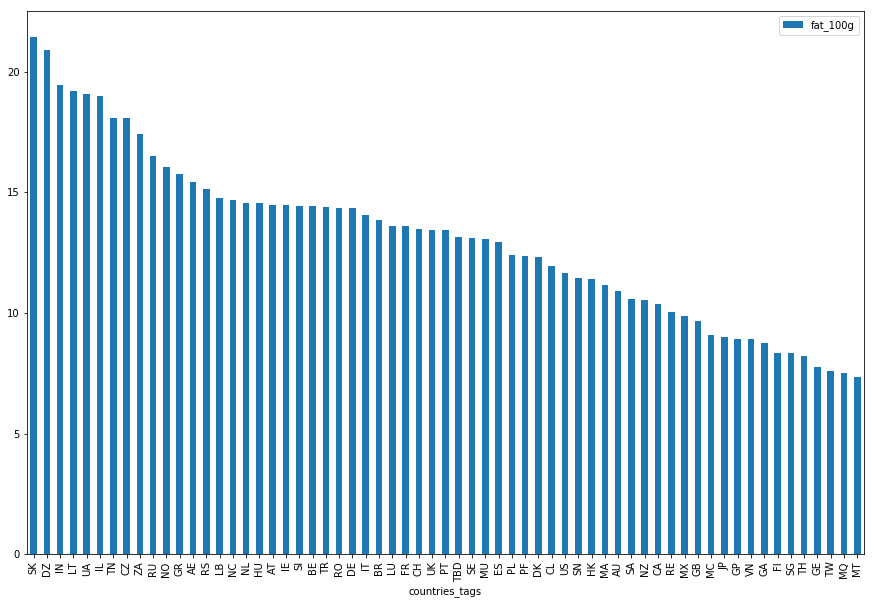

In [24]:
#remove null values
fat = means[['fat_100g']].dropna()
#remove outliers
fat = fat[fat['fat_100g'] <= 100]
#remove values with small sample
fat = fat[counted['fat_100g'] > 20]
#sort
fat.sort_values(by=['fat_100g'], ascending=False, inplace=True)
fat.plot.bar(figsize=(15,10))

In [25]:
def corr_scatter(df1, df2, merge_on, x_, y_, title_):
    merge = pd.merge(df1, df2, on=merge_on)
    merge.plot(kind='scatter',x=x_,y=y_, title=title_)
    print('Pearson correlation: ', merge.corr(method='pearson').iloc[0][1])
    print('Kendall correlation: ', merge.corr(method='kendall').iloc[0][1])
    print('Spearman correlation: ', merge.corr(method='spearman').iloc[0][1])

Pearson correlation:  0.313078891447
Kendall correlation:  0.185867895545
Spearman correlation:  0.252592165899


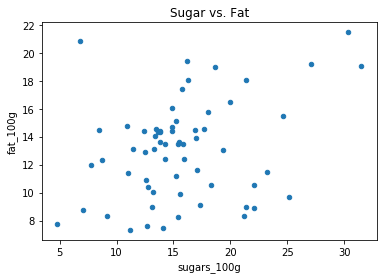

In [26]:
corr_scatter(sugar, fat, 'countries_tags', 'sugars_100g', 'fat_100g', 'Sugar vs. Fat')

We can see which countries consume the most fat according to our datas. 
We can guess some correlations, for instance (Slovakia are on the top of the ranking for each aspect) and some independant values (Germany use a lot of fat but not so much sugar), but we would need to calculate to be sure (next milestone)

We get the union of the sugar and fat datas to filter some other results.

In [27]:
indexes = pd.DataFrame(np.concatenate((sugar.index.values,fat.index.values)))
indexes = indexes.drop_duplicates()

In [28]:
indexes.head()

,0
0,UA
1,SK
2,LT
3,GB
4,AE


In [29]:
overweight.head()

,Entity,Code,Year,Indicator
0,Afghanistan,AFG,1975,0.5
1,Afghanistan,AFG,1976,0.5
2,Afghanistan,AFG,1977,0.6
3,Afghanistan,AFG,1978,0.6
4,Afghanistan,AFG,1979,0.6


In [30]:
overweight_datas = overweight.copy()
#choose data for a specific year. Unfortunately our dataset only goes up until 2016, so we choose that year.
overweight_datas = overweight_datas[overweight_datas['Year'] == 2016]
overweight_datas['Entity'] = overweight_datas['Entity'].apply(lambda x: x.lower().replace(' ', '-'))

In [31]:
#get country codes
overweight_datas = overweight_datas.apply(lambda x: get_tag(x, 'Entity', 'Code'), axis=1)

In [32]:
overweight_datas.head()

,Entity,Code,Year,Indicator
41,afghanistan,AF,2016,5.5
83,albania,AL,2016,21.7
125,algeria,DZ,2016,27.4
167,andorra,AD,2016,25.6
209,angola,TBD,2016,8.2


In [33]:
#overweight_datas[overweight_datas['Code'] == 'TBD']['Entity']

In [34]:
#remove rows with no country code
overweight_datas = overweight_datas[overweight_datas['Code'] != 'TBD']
#set index so it's easier to plot
overweight_datas = overweight_datas.set_index(['Code'])
overweight_datas

,Entity,Year,Indicator
Code,,,
AF,afghanistan,2016,5.5
AL,albania,2016,21.7
DZ,algeria,2016,27.4
AD,andorra,2016,25.6
AR,argentina,2016,28.3
AM,armenia,2016,20.2
AU,australia,2016,29.0
AT,austria,2016,20.1
AZ,azerbaijan,2016,19.9


In [35]:
#keep relevant column
overweight_datas = overweight_datas[['Indicator']]

In [36]:
#sort values
overweight_datas = overweight_datas.sort_values(by=['Indicator'], ascending=False)

In [37]:
overweight_datas.head()

,Indicator
Code,
KW,37.9
US,36.2
JO,35.5
SA,35.4
QA,35.1


In [38]:
overweight_datas = overweight_datas[overweight_datas.index.isin(indexes[0])]

In [39]:
overweight_datas

,Indicator
Code,
US,36.2
SA,35.4
TR,32.1
LB,32.0
AE,31.7
NZ,30.8
CA,29.4
AU,29.0
MX,28.9


In [40]:
overweight_datas = overweight_datas.rename(columns={'Indicator':'Overweight Prevalence'})
overweight_datas.index.name = 'countries_tags'

In [41]:
overweight_datas

,Overweight Prevalence
countries_tags,
US,36.2
SA,35.4
TR,32.1
LB,32.0
AE,31.7
NZ,30.8
CA,29.4
AU,29.0
MX,28.9


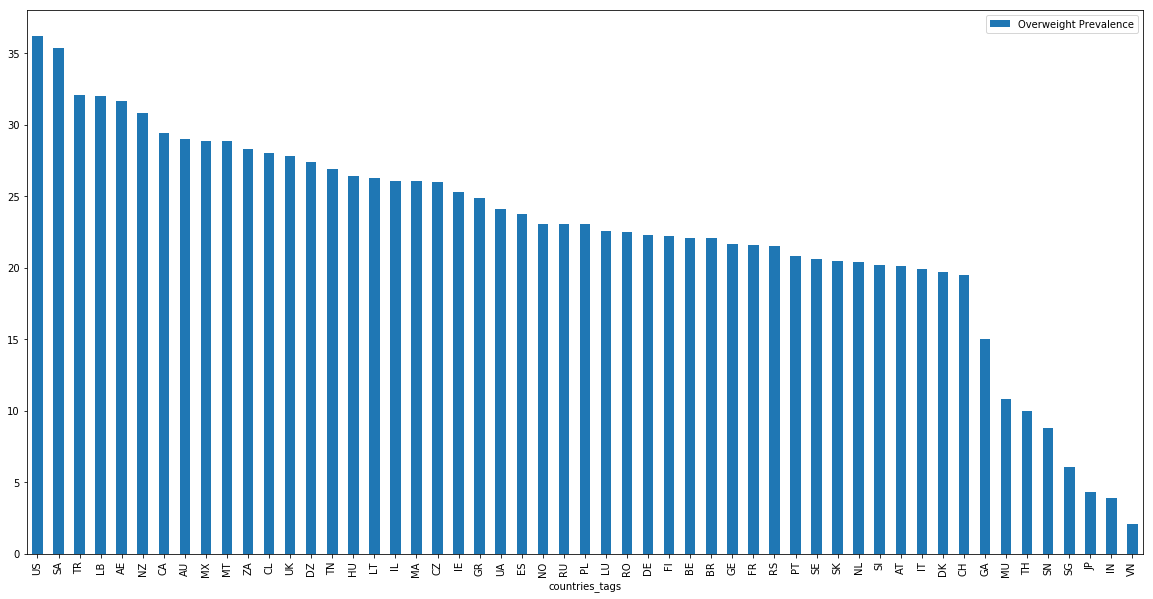

In [42]:
overweight_datas.plot.bar(figsize=(20,10))

Pearson correlation:  0.18924103823
Kendall correlation:  0.110545717663
Spearman correlation:  0.129231266786


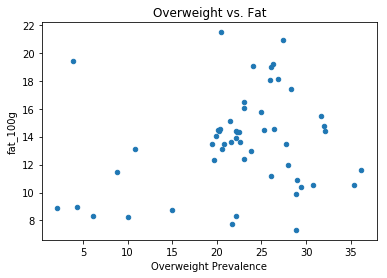

In [43]:
corr_scatter(fat, overweight_datas,'countries_tags', 'Overweight Prevalence', 'fat_100g', 'Overweight vs. Fat')

Pearson correlation:  -0.136664459753
Kendall correlation:  -0.018909135916
Spearman correlation:  -0.046370033324


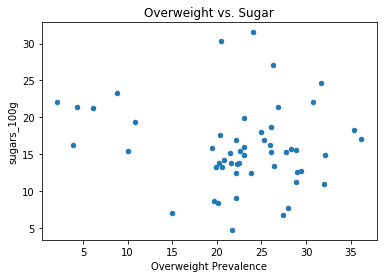

In [44]:
corr_scatter(sugar, overweight_datas,'countries_tags', 'Overweight Prevalence', 'sugars_100g', 'Overweight vs. Sugar')

As we can see : It is difficult to guess a correlation between the previous obsrvations (sugar & fat) and the obesity percentage displayed above. 
For example the slovakia is in the mean (for the obesity) but not really for the sugar & fat. That is only a guess we have to provide a scatter plot to proove it.

In [45]:
#drop some useless columns
to_drop=['prev', 'Unnamed: 5']
diab = diabetes.drop(to_drop, axis=1)
#select relevant columns
diab=diab[['country/territory', 'Diabetes [18-99] national prevalence[%]']]
#convert string column to numeric, in order to plot it, remove % at the end
diab['Diabetes [18-99] national prevalence[%]'] = pd.to_numeric(diab['Diabetes [18-99] national prevalence[%]'].str[:-1])

In [46]:
#get country codes
diab['country/territory'] = diab['country/territory'].apply(lambda x: str(x).lower().replace(' ', '-'))
diab = diab.apply(lambda x: get_tag(x, 'country/territory', 'code'), axis=1)

diab

,country/territory,Diabetes [18-99] national prevalence[%],code
0,afghanistan,6.15,AF
1,albania,11.93,AL
2,algeria,6.88,DZ
3,andorra,12.70,AD
4,angola,2.92,TBD
5,anguilla,12.80,TBD
6,antigua-and-barbuda,13.40,TBD
7,argentina,5.82,AR
8,armenia,7.56,AM
9,aruba,14.25,AW


In [47]:
# TODO fix this
diab[diab['code'] == 'TBD'][40:]

,country/territory,Diabetes [18-99] national prevalence[%],code
102,republic-of-korea,9.06,TBD
104,kyrgyzstan,6.05,TBD
105,lao-people's-democratic-republic,2.81,TBD
108,lesotho,2.48,TBD
109,liberia,1.83,TBD
114,macedonia,12.14,TBD
118,maldives,7.46,TBD
121,marshall-islands,31.38,TBD
126,federated-states-of-micronesia,10.13,TBD
133,myanmar,3.84,TBD


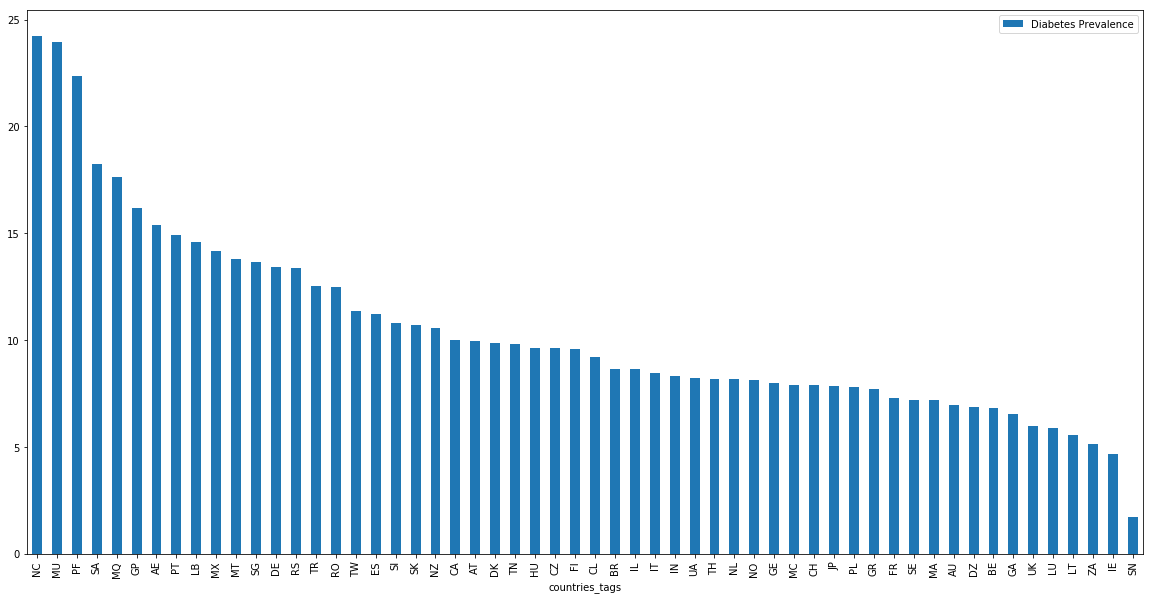

In [48]:

#remove rows without country codes
diab = diab[diab['code'] != 'TBD']
#set index for more agreable plotting
diab.set_index('code', inplace=True)
diab = diab[diab.index.isin(indexes[0])]
#sort values
diab= diab.sort_values(by=['Diabetes [18-99] national prevalence[%]'],ascending=False)
diab = diab.rename(columns={'Diabetes [18-99] national prevalence[%]':'Diabetes Prevalence'})
diab.index.name = 'countries_tags'
diab.plot.bar(figsize=(20,10))

Pearson correlation:  -0.170234297715
Kendall correlation:  -0.105194805195
Spearman correlation:  -0.156254272044


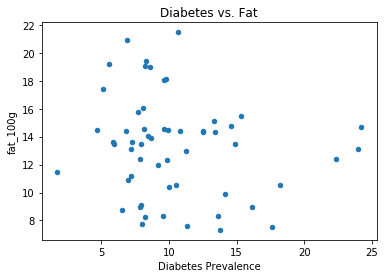

In [49]:
corr_scatter(fat, diab,'countries_tags', 'Diabetes Prevalence', 'fat_100g', 'Diabetes vs. Fat')

Pearson correlation:  -0.015878006802
Kendall correlation:  -0.0168831168831
Spearman correlation:  -0.0605604921394


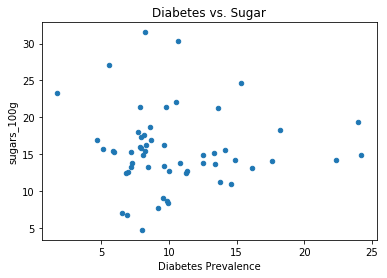

In [50]:
corr_scatter(sugar, diab,'countries_tags', 'Diabetes Prevalence', 'sugars_100g', 'Diabetes vs. Sugar')

Pearson correlation:  0.115910410778
Kendall correlation:  0.103843147847
Spearman correlation:  0.145127984149


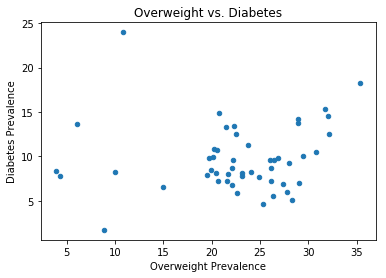

In [51]:
corr_scatter(overweight_datas, diab,'countries_tags', 'Overweight Prevalence', 'Diabetes Prevalence', 'Overweight vs. Diabetes')

Like for the obesity : it is difficult to guess a correlation between the previous obsrvations (sugar & fat) and the diabetes percentage display above. Same example : slovakia is in just after the middle but not really for the sugar & fat. Once more that is only a guess we have to provide a scatter plot to proove it.

### Summarize
We selected the datas who have an interest for us. We parse them to be able to get some results from it. We already get some results concerning alimentation quality of different countries. The really next step is to prove if a correlation exists between our results. (We have some guesses, but we have to provide a scatter plot and a correlation coefficient to proove it)

### What comes next

First, we reoriented our approach of our study. 
We decided to globalize our approach and not to focus our work only on the european countries. 
Indeed not too many countries have relevant data so we can include all of them.

We spent a lot of time on cleaning the datasets, so we focused our milestone on the countries part. 
We now will be able to have more relevant results, such as a visualization of the correlation (or not) between features.
We will focus on the food quality in the next steps, such as finding which particular foods have a higher sugar or fat content, instead of just comparing the countries. 

#### Research questions 
As we discussed above we did not yet work on the food quality, so we are not able to answer our research questions for the moment. We have to extract more data and try to find a correlation with the ones we already have. 

### IHD 

In [52]:
ihd

,Country,IHD
0,USA,445.8
1,Germany,155.8
2,Japan,105.5
3,United Kingdom,92.3
4,Italy,87.8
5,Poland,79.0
6,Spain,43.5
7,France,42.6
8,Canada,42.0
9,Hungary,33.6


In [53]:
ihd_df = ihd.copy()
ihd_df['IHD'] = ihd_df['IHD'].apply(lambda x: x*1000)
ihd_df['Country'] = ihd_df['Country'].apply(lambda x: str(x).lower().replace(' ', '-'))
ihd_df = ihd_df.apply(lambda x: get_tag(x, 'Country', 'code'), axis=1)
ihd_df = ihd_df[ihd_df['code'] != 'TBD']
ihd_df = ihd_df.set_index(['code'])
#ihd_df[ihd_df.index == 'US']
ihd_df

,Country,IHD
code,,
US,usa,445800.0
DE,germany,155800.0
JP,japan,105500.0
UK,united-kingdom,92300.0
IT,italy,87800.0
PL,poland,79000.0
ES,spain,43500.0
FR,france,42600.0
CA,canada,42000.0


In [54]:
population['Country'] = population['Country'].apply(lambda x: str(x).lower().replace(' ', '-'))
population = population.apply(lambda x: get_tag(x, 'Country', 'code'), axis=1)
population = population[population['code'] != 'TBD']
population = population.set_index(['code'])
population.head()

,Country,Population
code,,
CN,china,1321851888
IN,india,1129866154
US,united-states,301139947
ID,indonesia,234693997
BR,brazil,190010647


In [55]:
ihd_df

,Country,IHD
code,,
US,usa,445800.0
DE,germany,155800.0
JP,japan,105500.0
UK,united-kingdom,92300.0
IT,italy,87800.0
PL,poland,79000.0
ES,spain,43500.0
FR,france,42600.0
CA,canada,42000.0


In [56]:
population

,Country,Population
code,,
CN,china,1321851888
IN,india,1129866154
US,united-states,301139947
ID,indonesia,234693997
BR,brazil,190010647
PK,pakistan,164741924
BD,bangladesh,150448339
RU,russia,141377752
NG,nigeria,135031164


In [57]:
pop_ihd = ihd_df.merge(population, left_index=True, right_index=True)
pop_ihd.drop(columns=['Country_y'], inplace=True)
pop_ihd['IHD_%'] = ""

In [58]:
#for index, data in pop_ihd.iterrows():
#    data['IHD_%'] = data['IHD'] / data['Population'] * 100
    
def find_percentage(row):
    row['IHD_%'] =  row['IHD'] / row['Population'] * 100
    return row

pop_ihd = pop_ihd.apply(find_percentage, axis=1)
pop_ihd.index.name = 'countries_tags'
#pop_ihd[pop_ihd['IHD_%'] > 0.5]
pop_ihd

,Country_x,IHD,Population,IHD_%
countries_tags,,,,
US,usa,445800.0,301139947,0.148037
DE,germany,155800.0,82400996,0.189075
JP,japan,105500.0,127433494,0.082788
UK,united-kingdom,92300.0,60776238,0.151869
IT,italy,87800.0,58147733,0.150995
PL,poland,79000.0,38518241,0.205098
ES,spain,43500.0,40448191,0.107545
FR,france,42600.0,63718187,0.066857
CA,canada,42000.0,33390141,0.125786


In [59]:
def from_2_to_3_country_code(country_tag_2):
    code = countries_infos[countries_infos['COUNTRY_ALPHA2_CODE'] == country_tag_2]['COUNTRY_ALPHA3_CODE'].drop_duplicates()
    if code.size != 1:
        return 'TBD'
    else:
        return code.iloc[0]

In [60]:
def get_code_from_json(json_object):
    found = re.search('.id.\s*:\s*.(\w\w\w).', json_object, re.IGNORECASE)  
    #print(json_object)
    if found:
        json_object = found.group(1)
    return json_object

In [61]:
def get_map(data, values_name):
    data_for_map = data.reset_index()
    data_for_map['countries_tags'] = data_for_map['countries_tags'].apply(lambda x: from_2_to_3_country_code(x))
    
    countries_shapes['features'] = countries_shapes['features'].apply(lambda x: get_code_from_json(str(x)))

    for code in countries_shapes['features']:
        if len(code) != 3:
            continue

        if data_for_map[data_for_map['countries_tags'] == code].size == 0:
            test = pd.DataFrame(columns=['data_for_map', values_name])
            
            dTest = {
                'countries_tags' : code,
                values_name : 0
            }
            
            data_for_map = data_for_map.append(dTest, ignore_index=True)
            
        
            
    # Setup a folium map at a high-level zoom
    map = folium.Map(location=[30, 0], zoom_start=2)

    # choropleth maps bind Pandas Data Frames and json geometries.
    #This allows us to quickly visualize data combinations
    map.choropleth(geo_data=DATA_FOLDER + '/' + JSON_COUNTRIES_FILE, data=data_for_map,
                 columns=['countries_tags', values_name],
                 key_on='feature.id',
                 fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.2,
                 legend_name=values_name)
    return map

In [62]:
sugar_map = get_map(sugar, 'sugars_100g')
sugar_map

In [63]:
fat_map = get_map(fat, 'fat_100g')
fat_map

In [64]:
ow_data = get_map(overweight_datas, 'Overweight Prevalence')
ow_data

In [65]:
prot_map = get_map(means[['proteins_100g']], 'proteins_100g')
prot_map

In [66]:
diab_map = get_map(diab[['Diabetes Prevalence']], 'Diabetes Prevalence')
diab_map

In [67]:
ihd_map = get_map(pop_ihd[['IHD_%']], 'IHD_%')
ihd_map

### Playground

In [68]:
data = all_datas.copy()
data['countries_tags'].replace(regex=True, inplace=True, to_replace=r'\w\w:', value=r'')
data = data[data['sugars_100g'] <= 100]
data = data[data['fat_100g'] <= 100]

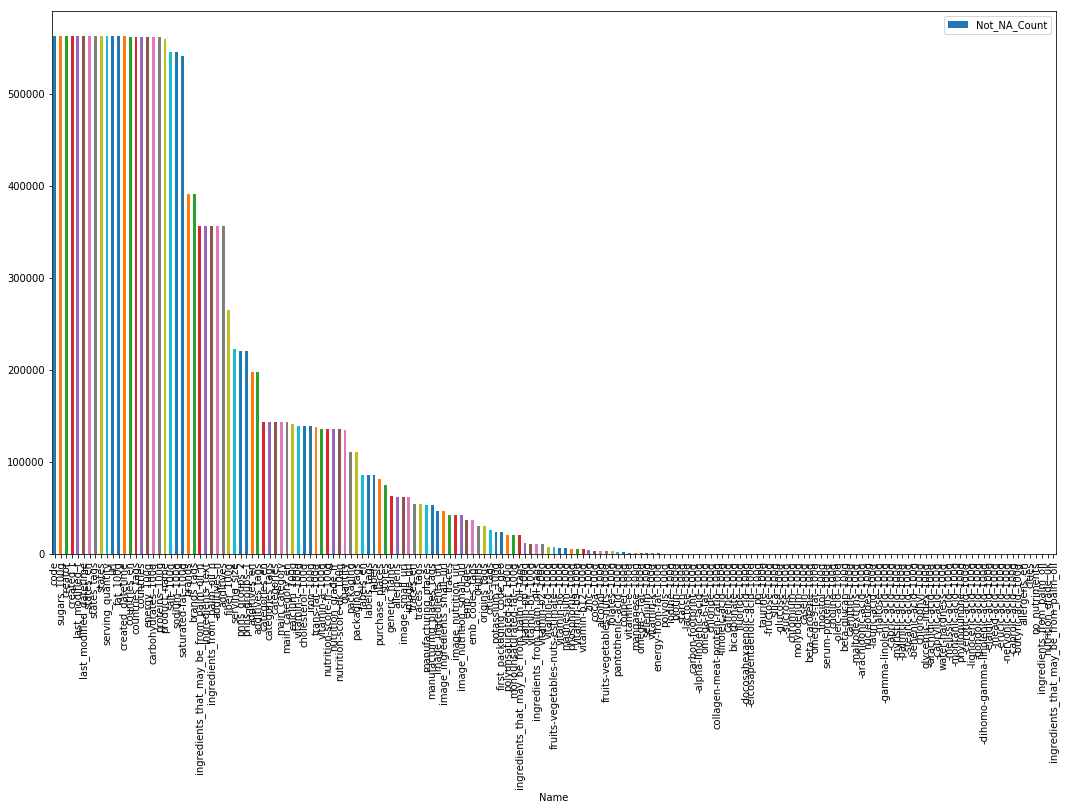

In [69]:
not_na = []
for c in data.columns.values: 
    count = data[c].notna().sum()
    not_na.append((c, count))
df = pd.DataFrame(not_na, columns=['Name','Not_NA_Count'])
df.sort_values(by='Not_NA_Count', inplace=True, ascending=False)
df = df.reset_index(drop=True)
df.plot(kind='bar',x='Name', y='Not_NA_Count', figsize=(18,10))

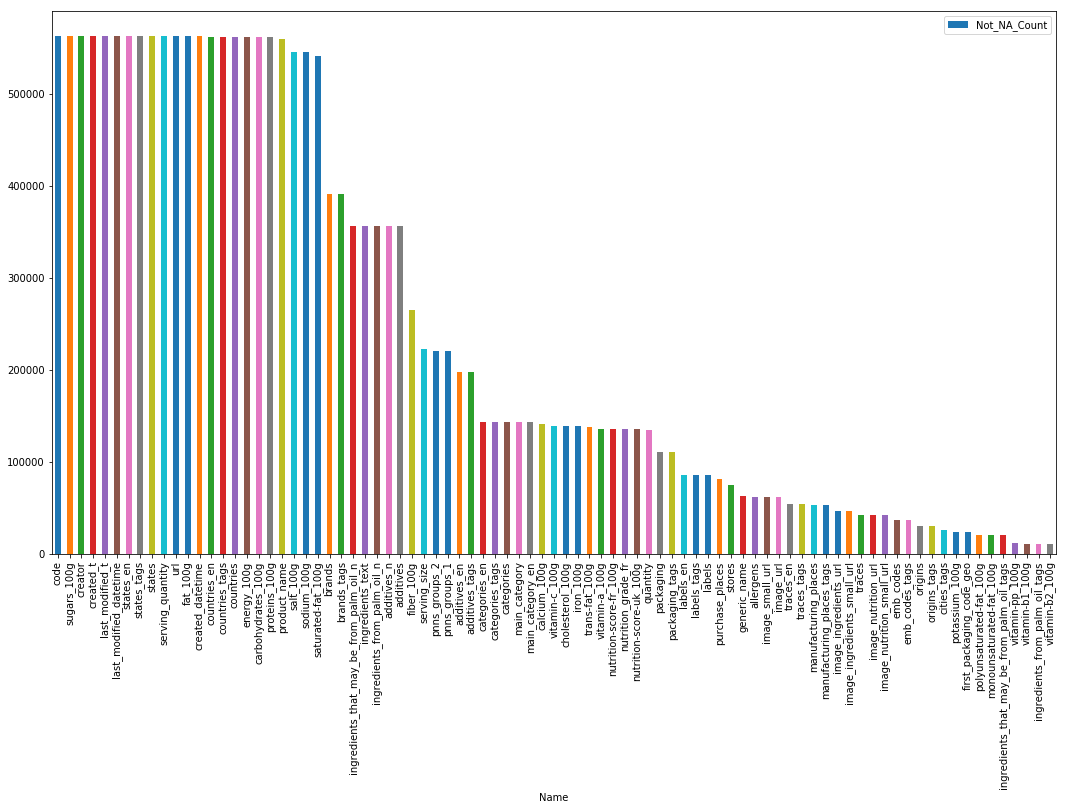

In [70]:
df_2 = df[df['Not_NA_Count'] > 10000]
df_2.plot(kind='bar',x='Name', y='Not_NA_Count', figsize=(18,10))

In [71]:
to_keep = ['sugars_100g','serving_quantity','fat_100g','energy_100g','carbohydrates_100g','proteins_100g',
           'product_name','salt_100g','sodium_100g','saturated-fat_100g','ingredients_that_may_be_from_palm_oil_n',
           'ingredients_text','ingredients_from_palm_oil_n', 'additives_n','additives','fiber_100g','serving_size',
           'additives_en','additives_tags','calcium_100g','vitamin-c_100g','cholesterol_100g',
           'iron_100g','trans-fat_100g','vitamin-a_100g','allergens','traces_en',
           'manufacturing_places','potassium_100g','vitamin-b1_100g','vitamin-b2_100g']

to_keep_red = ['sugars_100g','serving_quantity','fat_100g','energy_100g','carbohydrates_100g','proteins_100g',
           'product_name','salt_100g','sodium_100g','saturated-fat_100g','ingredients_that_may_be_from_palm_oil_n',
           'ingredients_text','ingredients_from_palm_oil_n', 'additives_n','additives','fiber_100g','serving_size',
           'additives_en']

to_keep_red_2 = ['sugars_100g','serving_quantity','fat_100g','energy_100g','carbohydrates_100g','proteins_100g',
                 'product_name','salt_100g','sodium_100g','saturated-fat_100g','ingredients_text', 'additives',
                 'fiber_100g','serving_size', 'additives_en']

In [72]:
data = data[to_keep_red_2]
data

,sugars_100g,serving_quantity,fat_100g,energy_100g,carbohydrates_100g,proteins_100g,product_name,salt_100g,sodium_100g,saturated-fat_100g,ingredients_text,additives,fiber_100g,serving_size,additives_en
0,15.00,0,7.00,1569.0,70.10,7.80,Vitória crackers,1.400,0.551181,3.08,NaN,NaN,NaN,NaN,NaN
2,0.40,0,0.00,88.0,4.80,0.20,Sauce Sweety chili 0%,2.040,0.803150,0.00,NaN,NaN,NaN,NaN,NaN
4,3.90,0,0.30,134.0,5.30,0.90,Salade de carottes râpées,0.420,0.165354,0.10,NaN,NaN,NaN,NaN,NaN
5,16.30,0,4.90,540.0,16.30,4.40,Fromage blanc aux myrtilles,0.250,0.098425,3.10,NaN,NaN,NaN,NaN,NaN
8,1.80,0,3.30,929.0,38.40,11.70,Baguette parisien,0.678,0.266929,2.10,NaN,NaN,NaN,NaN,NaN
9,2.00,0,9.40,1213.0,41.00,12.50,&quot;Baguette Lyonnais&quot;,0.900,0.354331,4.50,NaN,NaN,NaN,NaN,NaN
10,1.70,0,5.90,916.0,30.30,9.70,Solène céréales poulet,0.464,0.182677,0.50,"antioxydant : érythorbate de sodium, colorant ...",[ antioxydant -> fr:antioxydant ] [ erythor...,2.8,NaN,"E150 - Caramel,E160a - Alpha-carotene,E202 - P..."
11,21.90,0,22.00,1594.0,27.30,4.60,Tarte noix de coco,0.100,0.039370,15.50,NaN,NaN,4.4,NaN,NaN
12,23.00,0,0.00,418.0,24.00,0.00,Salade de fruits exotiques,3.200,1.259843,0.00,NaN,NaN,NaN,NaN,NaN
13,20.00,0,21.00,657.0,39.00,7.80,Chouquettes x 30,1.500,0.590551,12.00,NaN,NaN,NaN,NaN,NaN


In [73]:
parsed_datas.sort_values(by='sugars_100g', ascending=False)[0:100]

,product_name,countries,countries_tags,sugars_100g,fat_100g,serving_quantity,energy_100g,carbohydrates_100g,proteins_100g,salt_100g,sodium_100g,saturated-fat_100g,ingredients_text,additives,fiber_100g,serving_size,additives_en
200686,Sprinkles,united-states,US,100.0,0.0,0,1674.0,100.0,0.0,0.00000,0.000000,NaN,"Sugar, fd&c red 40 lake and carnauba wax.",[ sugar -> en:sugar ] [ fd-c-red-40-lake-an...,NaN,4 g (1 tsp),E903 - Carnauba wax
160691,Edible Decor Red Sugar Crystals,united-states,US,100.0,0.0,0,1745.0,100.0,0.0,0.00000,0.000000,0.0,"Sugar, confectioner's glaze, fd&c red 3, red 4...",[ sugar -> en:sugar ] [ confectioner-s-glaz...,0.0,6 g (1 tsp),"E127 - Erythrosine,E903 - Carnauba wax"
579666,Sucre en Poudre Blanc,france,FR,100.0,0.0,0,1700.0,100.0,0.0,0.00000,0.000000,0.0,Sucre en poudre,[ sucre-en-poudre -> fr:sucre-en-poudre ] [...,0.0,NaN,NaN
227019,Sucre en Morceaux,france,FR,100.0,0.0,0,1674.0,100.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
10024,Decorating Glam Green Sanding Sugar,united-states,US,100.0,0.0,0,1569.0,100.0,0.0,0.00000,0.000000,0.0,"Sugar, carnauba wax, confectioner's glaze, yel...",[ sugar -> en:sugar ] [ carnauba-wax -> en:...,0.0,4 g (1 tsp),"E102 - Tartrazine,E133 - Brilliant blue FCF,E9..."
118146,Pure Cane Sugar,united-states,US,100.0,0.0,0,1569.0,100.0,0.0,0.00000,0.000000,NaN,Sugar.,[ sugar -> en:sugar ],NaN,4 g (1 tsp),NaN
145503,Peppermints Candy,united-states,US,100.0,0.0,0,2092.0,100.0,0.0,0.00000,0.000000,0.0,"Sorbitol, magnesium stearate, aspartame, natur...",[ sorbitol -> en:e420i -> exists -- ok ] ...,0.0,2 g (14 PIECES) | (ABOUT),"E133 - Brilliant blue FCF,E414 - Acacia gum,E4..."
151181,Popcorn Seasoning,united-states,US,100.0,0.0,0,2092.0,100.0,0.0,0.00000,0.000000,NaN,"Sugar, brown sugar, natural flavor, caramel co...",[ sugar -> en:sugar ] [ brown-sugar -> en:b...,NaN,1 g (0.25 tsp),E150a - Plain caramel
590272,Sticks de sucre de canne,switzerland,CH,100.0,0.0,0,1700.0,100.0,0.0,0.00000,0.000000,NaN,NaN,NaN,0.0,5 g,NaN
45466,Light Brown Sugar,united-states,US,100.0,0.0,0,1569.0,100.0,0.0,0.00000,0.000000,NaN,"Sugar, cane molasses.",[ sugar -> en:sugar ] [ cane-molasses -> en...,NaN,4 g (1 tsp),NaN
